# Desperdicios y optimización
En este notebook desarrollo el cálculo de métricas, KPIs y gráficos simples tales como:

## 1. Lectura de archivos limpios e importación de librerias

- Importación de librerias  

In [129]:
# Importado de librerías
import pandas as pd
import json
import matplotlib.pyplot as plt

- Lectura de archivos

In [130]:
dir_clean = r'..\data\clean'

df_items = pd.read_csv(dir_clean + r'\items_arg.csv')
df_indec = pd.read_csv(dir_clean + r'\indec.csv')
df_orders = pd.read_csv(dir_clean + r'\orders.csv')

## 2. Cálculo de ganancias
Tanto en:
- pesos $
- porcentajes %, donde el porcentaje sería en relación con la ganancia total -> ganancia total es el 100%, entonces ganancia neta es X%

In [131]:
# Uno las tablas
df_ventas = df_orders.merge(df_items, on="item", how="inner")

# Paso a datetime la columna
df_ventas["fecha_orden"] = pd.to_datetime(df_ventas["fecha_orden"])

ganancia_total = round(((df_ventas["cantidad"] * df_ventas["precio"]).sum()), 1)
gasto_total = round(((df_ventas["cantidad"] * df_ventas["costo_produccion"]).sum()), 1)

# Cálculo monetario $
ganancia_neta = round((ganancia_total - gasto_total), 1)

# Cálculo percentil %
porcentaje_neto = round(((ganancia_neta * 100) / ganancia_total), 2)

print(f'Las ganancias desde el {df_ventas["fecha_orden"].min()} hasta el {df_ventas["fecha_orden"].max()}:')
print(f' - ${ganancia_neta} pesos')
print(f' - Con un promedio de {porcentaje_neto}% de ganancia por cada venta')

Las ganancias desde el 2022-01-01 00:00:00 hasta el 2022-12-31 00:00:00:
 - $4354688495.1 pesos
 - Con un promedio de 80.4% de ganancia por cada venta


## 3. Cálculo de pérdidas
- Utilizando un promedio de pérdidas por fugas de un ~10% (estimado en data\README.md) donde está aplicado (el 10%) al costo de los insumos
- Y estimando que con una buena gestión podría reducirse en un 5%

In [132]:
perdida_optimizada = gasto_total * 0.05 
gasto_optimizado = round((gasto_total - (gasto_total * 0.05)), 1)

# Cálculo monetario $
ganancia_neta_opt = round((ganancia_total - gasto_optimizado), 1)

# Cálculo percentil %
porcentaje_neto_opt = round(((ganancia_neta_opt * 100) / ganancia_total), 2)

# Ganancias posibles
diferencia_ganancia = round((ganancia_neta_opt - ganancia_neta), 1)
diferencia_porcentaje = round((porcentaje_neto_opt - porcentaje_neto), 2)

print(f'Las ganancias optmizadas desde el {df_ventas["fecha_orden"].min()} hasta el {df_ventas["fecha_orden"].max()}:')
print(f' - ${ganancia_neta_opt} pesos -> Diferencia de {diferencia_ganancia}')
print(f' - Con un promedio de {porcentaje_neto_opt}% de ganancia por cada venta -> Diferencia del {diferencia_porcentaje}%')

Las ganancias optmizadas desde el 2022-01-01 00:00:00 hasta el 2022-12-31 00:00:00:
 - $4407772826.6 pesos -> Diferencia de 53084331.5
 - Con un promedio de 81.38% de ganancia por cada venta -> Diferencia del 0.98%


## 4. Visualización y comparación

- Creación de DataFrames a utilizar

In [133]:
# Crear DataFrame de ganancias optimizadas
df_ventas_optimizado = df_ventas.copy()
df_ventas_optimizado['costo_produccion'] = (
    df_ventas_optimizado['costo_produccion'] * 0.5
)

# Calcular ganancias
df_ventas['ganancia'] = df_ventas['precio'] - df_ventas['costo_produccion']
df_ventas['ganancia_optimizada'] = (
    df_ventas_optimizado['precio'] - df_ventas_optimizado['costo_produccion']
)

# Crear columna de día (granularidad diaria)
df_ventas["dia"] = df_ventas["fecha_orden"].dt.to_period("D").dt.to_timestamp()

# Agrupar por día
df_dia = (
    df_ventas.groupby("dia")[["ganancia", "ganancia_optimizada"]]
    .sum()
    .sort_index()
)

- Evolución temporal de ganancias

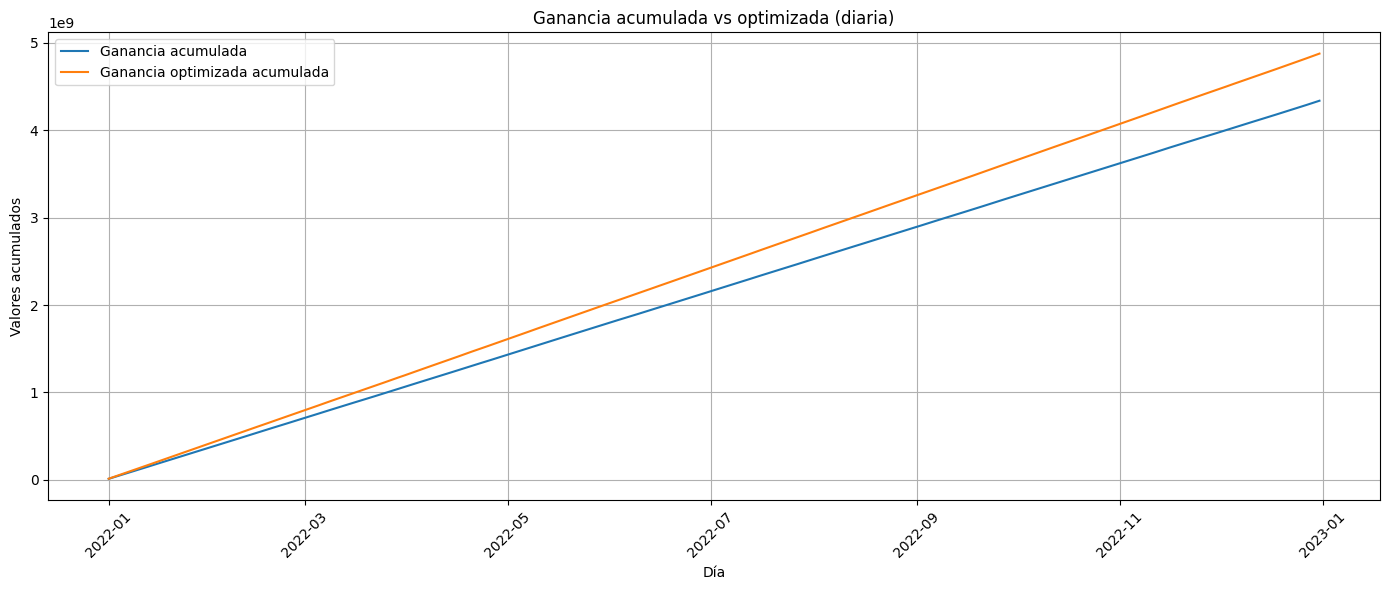

In [ ]:
# Ganancia acumulada
df_dia["ganancia_acum"] = df_dia["ganancia"].cumsum()
df_dia["ganancia_opt_acum"] = df_dia["ganancia_optimizada"].cumsum()

df_ventas["dia"] = df_ventas["fecha_orden"].dt.date

# Gráfico diario acumulado
plt.figure(figsize=(7,3))
plt.plot(df_dia.index, df_dia["ganancia_acum"], label="Ganancia acumulada")
plt.plot(df_dia.index, df_dia["ganancia_opt_acum"], label="Ganancia optimizada acumulada")

plt.title("Ganancia acumulada vs optimizada (diaria)")
plt.xlabel("Día")
plt.ylabel("Valores acumulados")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Podemos ver que, además de que el datasets de ventas es **terriblemente estable**, las diferencias entre la optimización y las ganancias originales son insignificantes

## 5. Almacenamiento
- Almaceno KPIs en JSON

In [135]:
kpis = {
    "ganancia_total": ganancia_total,
    "gasto_total": gasto_total,
    "ganancia_neta": ganancia_neta,
    "gasto_optimizado": gasto_optimizado,
    "ganancia_neta_opt": ganancia_neta_opt,
    "porcentaje_neto_opt": porcentaje_neto_opt,
    "diferencia_ganancia": diferencia_ganancia,
    "diferencia_porcentaje": diferencia_porcentaje
}

# Almacenado en JSON
with open(dir_clean + r"\kpis.json", "w") as f:
    json.dump(kpis, f)

- Almaceno dataset de ventas final para el reporte final

In [136]:
df_ventas.to_csv(dir_clean + r'\ventas.csv', index=False)
df_dia.to_csv(dir_clean + r'\ventas_diarias.csv', index=True)